In [1]:
import os
import gc
import copy
import time
import random
import string

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# For Transformer Models

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/fb3-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/fb3-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
#from transformers import AutoTokenizer, AutoModel, AutoConfig
#from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup


from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW, get_scheduler, get_linear_schedule_with_warmup, get_constant_schedule_with_warmup
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

%env TOKENIZERS_PARALLELISM=true

Found existing installation: transformers 4.20.1
Uninstalling transformers-4.20.1:
  Successfully uninstalled transformers-4.20.1


Found existing installation: tokenizers 0.12.1
Uninstalling tokenizers-0.12.1:
  Successfully uninstalled tokenizers-0.12.1


Looking in links: ../input/fb3-pip-wheels
Processing /kaggle/input/fb3-pip-wheels/transformers-4.21.2-py3-none-any.whl
Processing /kaggle/input/fb3-pip-wheels/tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.
allennlp 2.10.0 requires transformers<4.21,>=4.1, but you have transformers 4.21.2 which is incompatible.


Looking in links: ../input/fb3-pip-wheels


tokenizers.__version__: 0.12.1
transformers.__version__: 4.21.2
env: TOKENIZERS_PARALLELISM=true


In [2]:
df = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
y = df[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']]

In [3]:
CONFIG = {"seed": 2021,
          "epochs": 5,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 8,
          "max_length": 512,
          "learning_rate": 7e-6,
          "scheduler": 'CosineAnnealingLR',
          "gradient_checkpointing" : True,
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 5,
          "n_accumulate": 1,
          "num_classes": 1,
          "margin": 0.5,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

          }



#set notebook SEED
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [4]:
# ----- TOKENIZER -----
special_tokens_list = []
special_tokens_list.append('[BR]')
CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG["tokenizer"].save_pretrained('./tokenizer/')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/spm.model',
 './tokenizer/added_tokens.json',
 './tokenizer/tokenizer.json')

In [5]:
skf = KFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG['seed'])

for fold, ( _, val_) in enumerate(skf.split(X=df, y=y)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)
df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,kfold
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,3
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,0
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,3
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,3
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,3


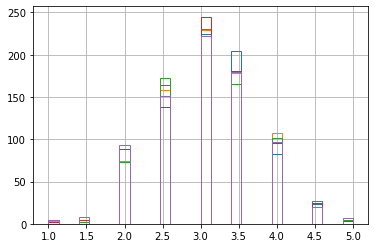

In [6]:
#get Kfold score distribution
for fold in df["kfold"].unique():
  #fig = plt.figure()
  df[df["kfold"] == fold]['conventions'].hist(bins = 30,  histtype=u'step')
  #print(df[df["kfold"] == fold]['y'].value_counts())

In [7]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings


#extend Dataset class
class FPDataset(torch.utils.data.Dataset):
   
    def __init__(self, texts, targets, tokenizer, seq_len=CONFIG['max_length']):        
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.seq_len = seq_len
    
    def __len__(self):
        """Returns the length of dataset."""
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])         
        tokenized = self.tokenizer(
            text,            
            max_length = self.seq_len,                                
            padding = "max_length",     # Pad to the specified max_length. 
            truncation = True,          # Truncate to the specified max_length. 
            add_special_tokens = True,  # Whether to insert [CLS], [SEP], <s>, etc.   
            return_attention_mask = True            
        )         
        return {"ids": torch.tensor(tokenized["input_ids"], dtype=torch.long),
                "masks": torch.tensor(tokenized["attention_mask"], dtype=torch.long),
                "target": torch.tensor(self.targets[idx], dtype=torch.float)
               }
    
class FPModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg['model_name'], output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
        else:
            self.config = torch.load(config_path)
            
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg['model_name'], config=self.config)
        else:
            self.model = AutoModel(self.config)
        if self.cfg['gradient_checkpointing']:
            self.model.gradient_checkpointing_enable()
            
        self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, 6)
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
        
    def feature(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, attention_mask)
        return feature

    def forward(self, input_ids, attention_mask):
        feature = self.feature(input_ids, attention_mask)
        output = self.fc(feature)
        return output
    
def loss_fn(predictions, targets):
    return torch.sqrt(nn.MSELoss()(predictions, targets))


In [8]:
def train_fn(data_loader, model, optimizer, device, scheduler):    
    
    model.train()                                # Put the model in training mode.              
    dataset_size = 0
    running_loss = 0.0

    lr_list = []
    train_losses = []         
    
    bar = tqdm(enumerate(data_loader), total=len(data_loader))

    for step, batch in bar:
        
        ids = batch["ids"].to(device, dtype=torch.long)
        masks = batch["masks"].to(device, dtype=torch.long)
        targets = batch["target"].to(device, dtype=torch.float) 
        
        optimizer.zero_grad()                    # To zero out the gradients.

        outputs = model(ids, masks).squeeze()  # Predictions from 1 batch of data.
        
        #print(outputs, targets)
        
        loss = loss_fn(outputs, targets)   
        #print(outputs.size(), targets.size(), loss.item())# Get the training loss.
        train_losses.append(loss.item())
        
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()
            lr_list.append(optimizer.param_groups[0]["lr"])
            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        #get progress bar
        batch_size = ids.size(0)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
        
    return train_losses, lr_list

In [9]:
@torch.no_grad()
def validate_fn(data_loader, model, device):
        
    model.eval()                                    # Put model in evaluation mode.
    dataset_size = 0
    running_loss = 0.0

    val_losses = []
        
    with torch.no_grad():                           # Disable gradient calculation.
        
        bar = tqdm(enumerate(data_loader), total=len(data_loader))

        for step, batch in bar:                  # Loop over all batches.
            
            ids = batch["ids"].to(device, dtype=torch.long)
            masks = batch["masks"].to(device, dtype=torch.long)
            targets = batch["target"].to(device, dtype=torch.float)

            outputs = model(ids, masks).squeeze() # Predictions from 1 batch of data.
            
            loss = loss_fn(outputs, targets)        # Get the validation loss.
            val_losses.append(loss.item())

            #get progress bar
            batch_size = ids.size(0)
            running_loss += (loss.item() * batch_size)
            dataset_size += batch_size
            
            epoch_loss = running_loss / dataset_size
            
            bar.set_postfix(Train_Loss=epoch_loss)
            
        gc.collect()
            
    return val_losses 

In [10]:
def plot_lr_schedule(learning_rates):
    x = np.arange(len(learning_rates))
    plt.plot(x, learning_rates)
    plt.title(f'Linear schedule')
    plt.ylabel("Learning Rate")
    plt.xlabel("Training Steps")
    plt.show()
    
def plot_train_val_losses(train_losses, val_losses, fold):
    x = np.arange(len(train_losses))
    plt.plot(x, train_losses, label="training loss", marker='o')
    plt.plot(x, val_losses, label="validation loss", marker='o')
    plt.legend(loc="best")   # to show the labels.
    plt.title(f'Fold {fold}: model')    
    plt.ylabel("RMSE")
    plt.xlabel(f"Epoch")    
    plt.show()

In [11]:
def run_training(df):  
    
    """
    run training
    """    
    EPOCHS = CONFIG['epochs']  
    FOLDS = [0,1,2,3,4]   # Set the list of folds you want to train
    EARLY_STOP_THRESHOLD = 3    
    TRAIN_BS = CONFIG['train_batch_size']             # Training batch size     
    VAL_BS = CONFIG['valid_batch_size']               # Validation batch size  
    cv = []                   # A list to hold the cross validation scores
    
    #=========================================================================
    # Prepare data and model for training
    #=========================================================================
    
    for fold in FOLDS:
        
        # Initialize the tokenizer
        tokenizer =  AutoTokenizer.from_pretrained(CONFIG['model_name'])

        # Fetch training data
        df_train = df[df["kfold"] != fold].reset_index(drop=True)

        # Fetch validation data
        df_val = df[df["kfold"] == fold].reset_index(drop=True)

        # Initialize training dataset
        train_dataset = FPDataset(df_train['full_text'].values, df_train[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].values, tokenizer)

        # Initialize validation dataset
        val_dataset = FPDataset(df_val['full_text'].values, df_val[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].values, tokenizer)

        # Create training dataloader
        train_data_loader = DataLoader(train_dataset, batch_size = TRAIN_BS,
                                       shuffle = True, num_workers = 2)

        # Create validation dataloader
        val_data_loader = DataLoader(val_dataset, batch_size = VAL_BS,
                                     shuffle = False, num_workers = 2)

        # Initialize the cuda device (or use CPU if you don't have GPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Load model and send it to the device.        
        model =  FPModel(CONFIG, config_path=None, pretrained=True)
        torch.save(model.config, './config.pth')
        model = model.to(device)
        

        # Get the AdamW optimizer
        optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'])

        # Calculate the number of training steps (this is used by scheduler).
        # training steps = [number of batches] x [number of epochs].
        train_steps = int(len(df_train) / TRAIN_BS * EPOCHS)    

        # Get the learning rate scheduler    
        scheduler = get_linear_schedule_with_warmup(                
                optimizer = optimizer,
                num_warmup_steps = int(train_steps*0.1),
                num_training_steps = train_steps
        )
        #scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
        #                                           eta_min=CONFIG['min_lr'])
        
        #cheduler = get_scheduler(
        #    name='constant_with_warmup',
        #    optimizer=optimizer,
        #    num_warmup_steps=int(train_steps*0.1),
        #    num_training_steps=train_steps,
        #)

        #=========================================================================
        # Training Loop - Start training the epochs
        #=========================================================================

        print(f"===== FOLD: {fold} =====")    
        best_rmse = 999
        early_stopping_counter = 0       
        all_train_losses = []
        all_val_losses = []
        all_lr = []

        for epoch in range(EPOCHS):

            # Call the train function and get the training loss
            train_losses, lr_list = train_fn(train_data_loader, model, optimizer, device, scheduler)
            train_loss = np.mean(train_losses)   
            all_train_losses.append(train_loss)
            all_lr.extend(lr_list)

            # Perform validation and get the validation loss
            val_losses = validate_fn(val_data_loader, model, device)
            val_loss = np.mean(val_losses)
            all_val_losses.append(val_loss)    

            rmse = val_loss

            # If there's improvement on the validation loss, save the model checkpoint.
            # Else do early stopping if threshold is reached.
            if rmse < best_rmse:            
                torch.save(model.state_dict(), f"model_base_LR_fold_{fold}.bin")
                print(f"FOLD: {fold}, Epoch: {epoch}, RMSE = {round(rmse,4)}, checkpoint saved.")
                best_rmse = rmse
                early_stopping_counter = 0
            else:
                print(f"FOLD: {fold}, Epoch: {epoch}, RMSE = {round(rmse,4)}")
                early_stopping_counter += 1
            if early_stopping_counter > EARLY_STOP_THRESHOLD:
                print(f"FOLD: {fold}, Epoch: {epoch}, RMSE = {round(rmse,4)}")
                print(f"Early stopping triggered! Best RMSE: {round(best_rmse,4)}\n")                
                break

        # Plot the losses and learning rate schedule.
        plot_train_val_losses(all_train_losses, all_val_losses, fold)
        plot_lr_schedule(all_lr)   
        
        # Keep the best_rmse as cross validation score for the fold.
        cv.append(best_rmse)
        
    # Print the cross validation scores and their average.
    cv_rounded = [ round(elem, 4) for elem in cv ] 
    print(f"CV: {cv_rounded}") 
    print(f"Average CV: {round(np.mean(cv), 4)}\n") 


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


===== FOLD: 0 =====


100%|██████████| 98/98 [00:25<00:00,  3.84it/s, Train_Loss=0.475]


FOLD: 0, Epoch: 0, RMSE = 0.4745, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.85it/s, Train_Loss=0.468]


FOLD: 0, Epoch: 1, RMSE = 0.4677, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.86it/s, Train_Loss=0.49]


FOLD: 0, Epoch: 2, RMSE = 0.4896


100%|██████████| 98/98 [00:25<00:00,  3.86it/s, Train_Loss=0.464]


FOLD: 0, Epoch: 3, RMSE = 0.4635, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.88it/s, Train_Loss=0.453]


FOLD: 0, Epoch: 4, RMSE = 0.4533, checkpoint saved.


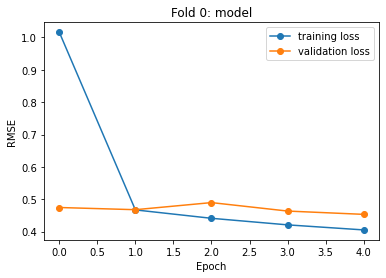

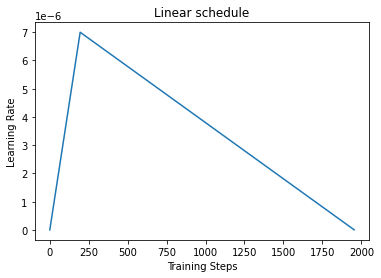

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT e

===== FOLD: 1 =====


100%|██████████| 98/98 [00:25<00:00,  3.85it/s, Train_Loss=0.497]


FOLD: 1, Epoch: 0, RMSE = 0.4965, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.83it/s, Train_Loss=0.47]


FOLD: 1, Epoch: 1, RMSE = 0.47, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.84it/s, Train_Loss=0.461]


FOLD: 1, Epoch: 2, RMSE = 0.4611, checkpoint saved.


100%|██████████| 98/98 [00:26<00:00,  3.76it/s, Train_Loss=0.472]


FOLD: 1, Epoch: 3, RMSE = 0.4718


100%|██████████| 98/98 [00:26<00:00,  3.76it/s, Train_Loss=0.453]


FOLD: 1, Epoch: 4, RMSE = 0.4526, checkpoint saved.


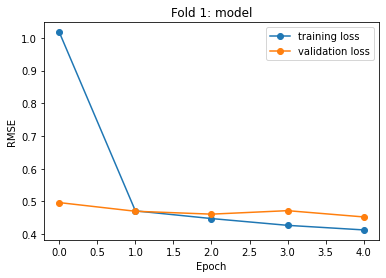

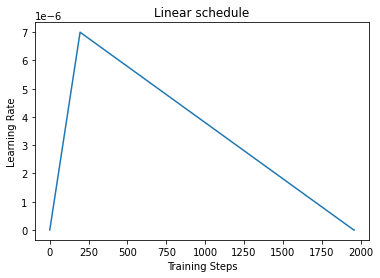

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT e

===== FOLD: 2 =====


100%|██████████| 98/98 [00:25<00:00,  3.82it/s, Train_Loss=0.485]


FOLD: 2, Epoch: 0, RMSE = 0.4844, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.84it/s, Train_Loss=0.473]


FOLD: 2, Epoch: 1, RMSE = 0.4727, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.83it/s, Train_Loss=0.46]


FOLD: 2, Epoch: 2, RMSE = 0.4596, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.84it/s, Train_Loss=0.457]


FOLD: 2, Epoch: 3, RMSE = 0.4564, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.79it/s, Train_Loss=0.458]


FOLD: 2, Epoch: 4, RMSE = 0.4582


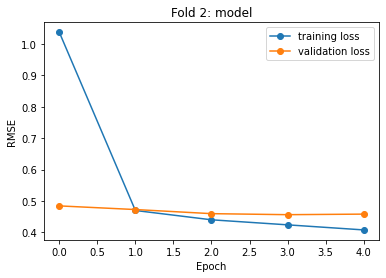

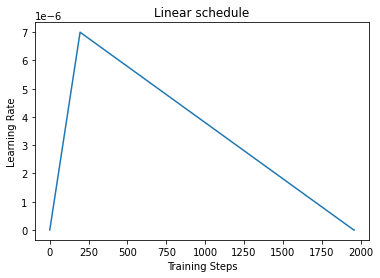

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT e

===== FOLD: 3 =====


100%|██████████| 98/98 [00:25<00:00,  3.87it/s, Train_Loss=0.506]


FOLD: 3, Epoch: 0, RMSE = 0.5066, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.82it/s, Train_Loss=0.459]


FOLD: 3, Epoch: 1, RMSE = 0.4594, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.83it/s, Train_Loss=0.461]


FOLD: 3, Epoch: 2, RMSE = 0.4611


100%|██████████| 98/98 [00:26<00:00,  3.76it/s, Train_Loss=0.454]


FOLD: 3, Epoch: 3, RMSE = 0.4534, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.84it/s, Train_Loss=0.457]


FOLD: 3, Epoch: 4, RMSE = 0.4566


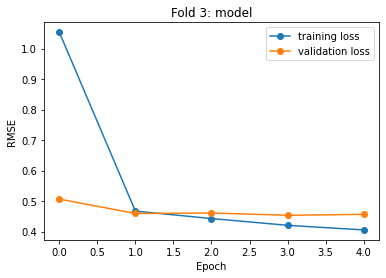

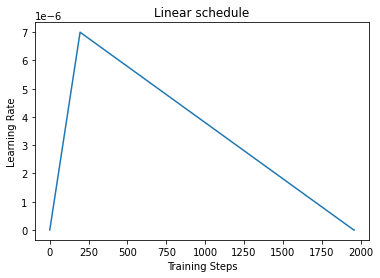

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT e

===== FOLD: 4 =====


100%|██████████| 98/98 [00:25<00:00,  3.82it/s, Train_Loss=0.484]


FOLD: 4, Epoch: 0, RMSE = 0.484, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.81it/s, Train_Loss=0.46]


FOLD: 4, Epoch: 1, RMSE = 0.4596, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.84it/s, Train_Loss=0.463]


FOLD: 4, Epoch: 2, RMSE = 0.4629


100%|██████████| 98/98 [00:25<00:00,  3.78it/s, Train_Loss=0.456]


FOLD: 4, Epoch: 3, RMSE = 0.4561, checkpoint saved.


100%|██████████| 98/98 [00:25<00:00,  3.83it/s, Train_Loss=0.455]


FOLD: 4, Epoch: 4, RMSE = 0.4545, checkpoint saved.


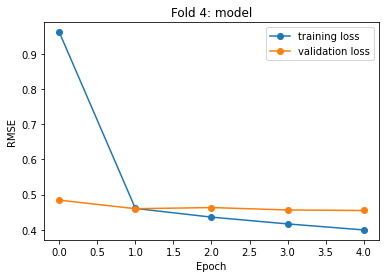

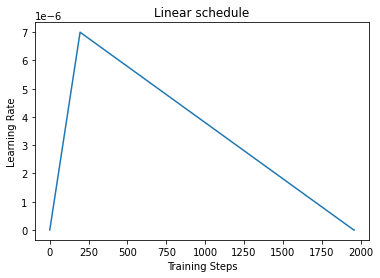

CV: [0.4533, 0.4526, 0.4564, 0.4534, 0.4545]
Average CV: 0.4541



In [12]:
run_training(df)